<a href="https://colab.research.google.com/github/harsh-kmr/Auto-Neural-Translator-English-to-Marathi/blob/main/Marathi_English_machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#marathi-english machine translation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from keras.utils import get_file
from sklearn.utils import shuffle
from keras.utils import pad_sequences
from keras.layers import LSTM, Input, Dense,Embedding
from keras.models import Model,load_model
from keras.utils import plot_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
import pickle as pkl
import numpy as np
import zipfile
import math

In [ ]:
link ="https://drive.google.com/uc?id=1ugCwkBnwzKRNhFjlG40EGTXk9ig3KdC3&export=download"
directory = './dataset/marathi-english'

In [ ]:
path_to_downloaded_file = get_file(
    "english-marathi",
    link,
    untar=False)

In [ ]:
path_to_downloaded_file

'/root/.keras/datasets/english-marathi'

In [ ]:
with zipfile.ZipFile(path_to_downloaded_file, 'r') as zip_ref:
    zip_ref.extractall(directory)

In [ ]:
path_to_txt = "/content/dataset/marathi-english/mar.txt"

In [ ]:
with open(path_to_txt,'r') as f:
  data = f.read()

In [ ]:
uncleaned_data_list = data.split('\n')
len(uncleaned_data_list)

46966

In [ ]:
uncleaned_data_list =  uncleaned_data_list[:35000]

In [ ]:
len(uncleaned_data_list)

35000

In [ ]:
english_word = []
marathi_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  english_word.append(word.split('\t')[:-1][0])
  marathi_word.append(word.split('\t')[:-1][1])

In [ ]:
len(english_word), len(marathi_word)

(35000, 35000)

In [ ]:
language_data = pd.DataFrame(columns=['English','Marathi'])
language_data['English'] = english_word
language_data['Marathi'] = marathi_word

In [ ]:
language_data.to_csv('language_data.csv', index=False)

In [ ]:
language_data = pd.read_csv('language_data.csv')

In [ ]:
language_data.head()

,English,Marathi
0,Go.,जा.
1,Run!,पळ!
2,Run!,धाव!
3,Run!,पळा!
4,Run!,धावा!


In [ ]:
language_data.tail()

,English,Marathi
34995,Your book has changed my life.,तुझ्या पुस्तकाने माझं आयुष्य बदलून टाकलं आहे.
34996,Your book has changed my life.,तुमच्या पुस्तकाने माझं आयुष्य बदलून टाकलं आहे.
34997,Your cell phone's not working.,तुझा सेलफोन चालत नाहीये.
34998,Your cell phone's not working.,तुमचा सेलफोन चालत नाहीये.
34999,"""Do you like to travel?"" ""Yes.""","""तुला प्रवास करायला आवडतो का?"" ""होय."""


In [ ]:
english_text = language_data['English'].values
marathi_text = language_data['Marathi'].values

In [ ]:
len(english_text), len(marathi_text)

(35000, 35000)

In [ ]:
english_text_ = [x.lower() for x in english_text]
marathi_text_ = [x.lower() for x in marathi_text]

In [ ]:
type(english_text_), type(marathi_text_)

(list, list)

In [ ]:
english_text_ = [re.sub("'",'',x) for x in english_text_]
marathi_text_ = [re.sub("'",'',x) for x in marathi_text_]

In [ ]:
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text

In [ ]:
english_text_ = remove_punc(english_text_)
marathi_text_ = remove_punc(marathi_text_)

In [ ]:
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

In [ ]:
marathi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in marathi_text_]
marathi_text_ = [re.sub("[\u200d]","",x) for x in marathi_text_]

In [ ]:
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

In [ ]:
marathi_text_ = ["start " + x + " end" for x in marathi_text_]

In [ ]:
X = english_text_
Y = marathi_text_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)

In [ ]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

In [ ]:
print(len(X_train))

print(len(y_train))

print(len(X_test))

print(len(y_test))

31500
31500
3500
3500


In [ ]:
max_length_english = Max_length(X_train)
max_lenght_marathi = Max_length(y_train)

In [ ]:
max_lenght_marathi, max_length_english

(12, 9)

In [ ]:
max_length_english_test = Max_length(X_test)
max_lenght_marathi_test = Max_length(y_test)

In [ ]:
max_lenght_marathi_test, max_length_english_test

(12, 8)

In [ ]:
def tokenizer_(text_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text_data)
  return tokenizer

tokenizer_input = tokenizer_(X)
vocab_size_input = len(tokenizer_input.word_index) + 1
tokenizer_target = tokenizer_(Y)
vocab_size_target = len(tokenizer_target.word_index) + 1

In [ ]:
vocab_size_input,vocab_size_target

(4152, 9662)

In [ ]:
def generate_batch(X= X_train,Y=y_train, batch_size=128):
  while True:
    for j in range(0, len(X), batch_size):
      encoder_data_input = np.zeros((batch_size,max_length_english),dtype='float32') #metrix of batch_size*max_length_english
      decoder_data_input = np.zeros((batch_size,max_lenght_marathi),dtype='float32') #metrix of batch_size*max_length_marathi
      decoder_target_input = np.zeros((batch_size,max_lenght_marathi,vocab_size_target),dtype='float32') # 3d array one hot encoder decoder target data
      for i, (input_text,target_text) in enumerate(zip(X[j:j+batch_size],Y[j:j+batch_size])):
        for t, word in enumerate(input_text.split()):
          encoder_data_input[i,t] = tokenizer_input.word_index[word] # Here we are storing the encoder 
                                                                     #seq in row here padding is done automaticaly as 
                                                                     #we have defined col as max_lenght
        for t, word in enumerate(target_text.split()):
          # if word == 'START_':
          #   word = 'start'
          # elif word == 'END_':
          #   word = 'end'
          decoder_data_input[i,t] = tokenizer_target.word_index[word] # same for the decoder sequence
          if t>0:
            decoder_target_input[i,t-1,tokenizer_target.word_index[word]] = 1 #target is one timestep ahead of decoder input because it does not have 'start tag'
      # print(encoder_data_input.shape())
      yield ([encoder_data_input,decoder_data_input],decoder_target_input)

In [ ]:
latent_dim = 128
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,),name="encoder_inputs")
emb_layer_encoder = Embedding(vocab_size_input,latent_dim, mask_zero=True)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(emb_layer_encoder)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name="decoder_inputs")
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
emb_layer_decoder = Embedding(vocab_size_target,latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(emb_layer_decoder, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_target, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

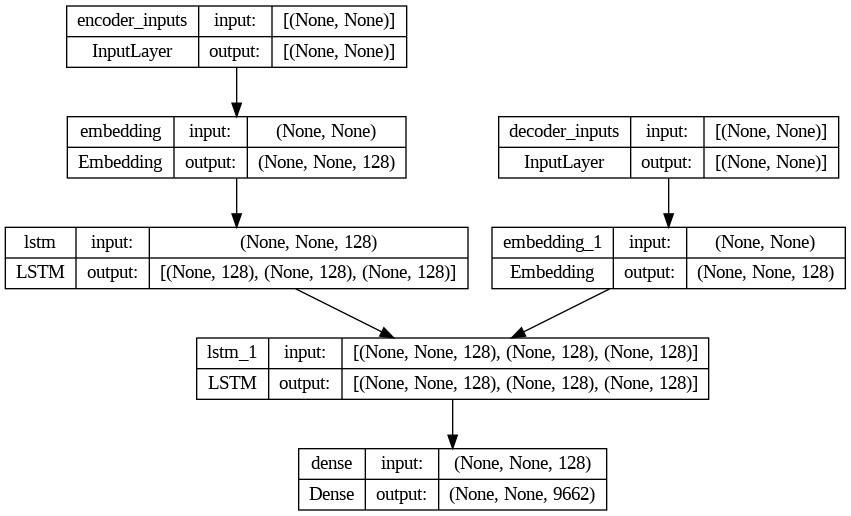

In [ ]:
plot_model(model, to_file='train_model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    531456      ['encoder_inputs[0][0]']         
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    1236736     ['decoder_inputs[0][0]']         
                                                                                              

In [ ]:
batch_size = 128
epochs = 50
train_steps = math.ceil(len(X_train) / batch_size)
val_steps = math.ceil(len(X_test) / batch_size)

In [ ]:
train_gen = generate_batch(X_train, y_train, 
                           batch_size)
valid_gen = generate_batch(X_test, y_test, 
                           batch_size)
model.fit(train_gen,
                    steps_per_epoch = train_steps,
                    epochs=epochs,
                    validation_data = valid_gen,
                    validation_steps = val_steps)

Epoch 1/50
247/247 [==============================] - 261s 957ms/step - loss: 5.1183 - accuracy: 0.1719 - val_loss: 4.5549 - val_accuracy: 0.1861
Epoch 2/50
247/247 [==============================] - 211s 857ms/step - loss: 4.3969 - accuracy: 0.1967 - val_loss: 4.3240 - val_accuracy: 0.2078
Epoch 3/50
247/247 [==============================] - 210s 849ms/step - loss: 4.1288 - accuracy: 0.2274 - val_loss: 4.0722 - val_accuracy: 0.2428
Epoch 4/50
247/247 [==============================] - 202s 817ms/step - loss: 3.8717 - accuracy: 0.2497 - val_loss: 3.8846 - val_accuracy: 0.2535
Epoch 5/50
247/247 [==============================] - 210s 850ms/step - loss: 3.6483 - accuracy: 0.2667 - val_loss: 3.6915 - val_accuracy: 0.2754
Epoch 6/50
247/247 [==============================] - 204s 826ms/step - loss: 3.4094 - accuracy: 0.2911 - val_loss: 3.4968 - val_accuracy: 0.2986
Epoch 7/50
247/247 [==============================] - 195s 791ms/step - loss: 3.1616 - accuracy: 0.3195 - val_loss: 3.3002 -

In [ ]:
latent_dim = 128
#inference encoder
encoder_inputs_inf = model.input[0] #Trained encoder input layer
encoder_outputs_inf, inf_state_h, inf_state_c = model.layers[4].output # retoring the encoder lstm output and states
encoder_inf_states = [inf_state_h,inf_state_c]
encoder_model = Model(encoder_inputs_inf,encoder_inf_states)

In [ ]:
#inference decoder
# The following tensor will store the state of the previous timestep in the "starting the encoder final time step"
decoder_state_h_input = Input(shape=(latent_dim,)) #becase during training we have set the lstm unit to be of 50
decoder_state_c_input = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_h_input,decoder_state_c_input]

# # inference decoder input
decoder_input_inf = model.input[1] #Trained decoder input layer
# decoder_input_inf._name='decoder_input'
decoder_emb_inf = model.layers[3](decoder_input_inf)
decoder_lstm_inf = model.layers[5]
decoder_output_inf, decoder_state_h_inf, decoder_state_c_inf = decoder_lstm_inf(decoder_emb_inf, initial_state =decoder_state_input)
decoder_state_inf = [decoder_state_h_inf,decoder_state_c_inf]
#inference dense layer
dense_inf = model.layers[6]
decoder_output_final = dense_inf(decoder_output_inf)# A dense softmax layer to generate prob dist. over the target vocabulary

decoder_model = Model([decoder_input_inf]+decoder_state_input,[decoder_output_final]+decoder_state_inf)

In [ ]:
reverse_word_map_input = dict(map(reversed, tokenizer_input.word_index.items()))
reverse_word_map_target = dict(map(reversed, tokenizer_target.word_index.items()))

In [ ]:
def decode_seq(input_seq):
  # print("input_seq=>",input_seq)
  state_values_encoder = encoder_model.predict(input_seq)
  # intialize the target seq with start tag
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tokenizer_target.word_index['start']
  # print("target_seq:=>",target_seq)
  stop_condition = False
  decoder_sentance = ''
  # print("Beforee the while loop")
  while not stop_condition:
    sample_word , decoder_h,decoder_c= decoder_model.predict([target_seq] + state_values_encoder)
    # print("sample_word: =>",sample_word)
    sample_word_index = np.argmax(sample_word[0,-1,:])
    # print("sample_word_index: ",sample_word_index)
    decoder_word = reverse_word_map_target[sample_word_index]
    decoder_sentance += ' '+ decoder_word
    # print("decoded word:=>",decoder_word)
    # print(len(decoder_sentance))
    # print("len(decoder_sentance) > 70: ",len(decoder_sentance) > 70)
    # print('decoder_word == "end"',decoder_word == 'end')
    # print(decoder_word == 'end' or len(decoder_sentance) > 70)
    # stop condition for the while loop
    if (decoder_word == 'end' or 
        len(decoder_sentance) > 70):
        stop_condition = True
        # print("from if condition")
    # target_seq = np.zeros((1,1))
    target_seq[0, 0] = sample_word_index
    # print(target_seq)
    state_values_encoder = [decoder_h,decoder_c]
  return decoder_sentance


In [ ]:
for i in range(100):
  sentance = X_test[i]
  original_target = y_test[i]
  input_seq = tokenizer_input.texts_to_sequences([sentance])
  pad_sequence = pad_sequences(input_seq, maxlen= 30, padding='post')
  # print('input_sequence =>',input_seq)
  # print("pad_seq=>",pad_sequence)
  predicted_target = decode_seq(pad_sequence)
  print("Test sentance: ",i+1)
  print("sentance: ",sentance)
  print("origianl translate:",original_target[6:-4])
  print("predicted Translate:",predicted_target[:-4])
  print("=="*50)

1/1 [==============================] - 0s 28ms/step
Test sentance:  1
sentance:  the kettle is boiling
origianl translate: किटलीतलं पाणी उकळतंय
predicted Translate:  सूर्य चमकतोय
1/1 [==============================] - 0s 27ms/step
Test sentance:  2
sentance:  is anyone looking
origianl translate: कोणी बघतय का
predicted Translate:  कोणी झालं आहे का
1/1 [==============================] - 0s 27ms/step
Test sentance:  3
sentance:  are you a republican
origianl translate: तू रिपब्लिकन आहेस का
predicted Translate:  तू रिपब्लिकन आहात का
1/1 [==============================] - 0s 30ms/step
Test sentance:  4
sentance:  is that what you want
origianl translate: तुला हेच हवं आहे का
predicted Translate:  तुम्हाला काय हवं आहे का
1/1 [==============================] - 0s 33ms/step
Test sentance:  5
sentance:  can cats eat bananas
origianl translate: मांजरी केळी खाऊ शकतात का
predicted Translate:  मांजरी केळी खराब झाली का
1/1 [==============================] - 0s 27ms/step
Test sentance:  6
sentance:  